In [ ]:
import numpy as np
import pandas as pd
from scipy.fft import fft, fftfreq
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [2]:
data = np.load("power_bands_data.npz")

In [4]:
list(data.keys())

['left_amygdala_power_bands',
 'right_amygdala_power_bands',
 'left_hippocampus_power_bands',
 'right_hippocampus_power_bands',
 'left_hippocampus_pos_power_bands',
 'labels']

In [6]:
labels = data['labels']
left_amygdala_power_bands = data['left_amygdala_power_bands']
right_amygdala_power_bands = data['right_amygdala_power_bands']
left_hippocampus_power_bands = data['left_hippocampus_power_bands']
right_hippocampus_power_bands = data['right_hippocampus_power_bands']

In [9]:
labels.shape, left_amygdala_power_bands.shape, right_amygdala_power_bands.shape, left_hippocampus_power_bands.shape, right_hippocampus_power_bands.shape

((320,), (320, 5), (320, 5), (320, 5), (320, 5))

In [ ]:
logistic_model = LogisticRegression(max_iter=1000)


# Cross-validation for each data source
results = {}

# Single models
results['left_amygdala'] = cross_val_score(logistic_model, left_amygdala_power_bands, labels, cv=5).mean()
results['right_amygdala'] = cross_val_score(logistic_model, right_amygdala_power_bands, labels, cv=5).mean()
results['left_hippocampus'] = cross_val_score(logistic_model, left_hippocampus_power_bands, labels, cv=5).mean()
results['right_hippocampus'] = cross_val_score(logistic_model, right_hippocampus_power_bands, labels, cv=5).mean()

# Concatenated models
left_right_amygdala = np.hstack((left_amygdala_power_bands, right_amygdala_power_bands))
results['left_right_amygdala'] = cross_val_score(logistic_model, left_right_amygdala, labels, cv=5).mean()

left_right_hippocampus = np.hstack((left_hippocampus_power_bands, right_hippocampus_power_bands))
results['left_right_hippocampus'] = cross_val_score(logistic_model, left_right_hippocampus, labels, cv=5).mean()

# All concatenated
all_data = np.hstack((left_amygdala_power_bands, right_amygdala_power_bands,
                      left_hippocampus_power_bands, right_hippocampus_power_bands))
results['all_concat'] = cross_val_score(logistic_model, all_data, labels, cv=5).mean()



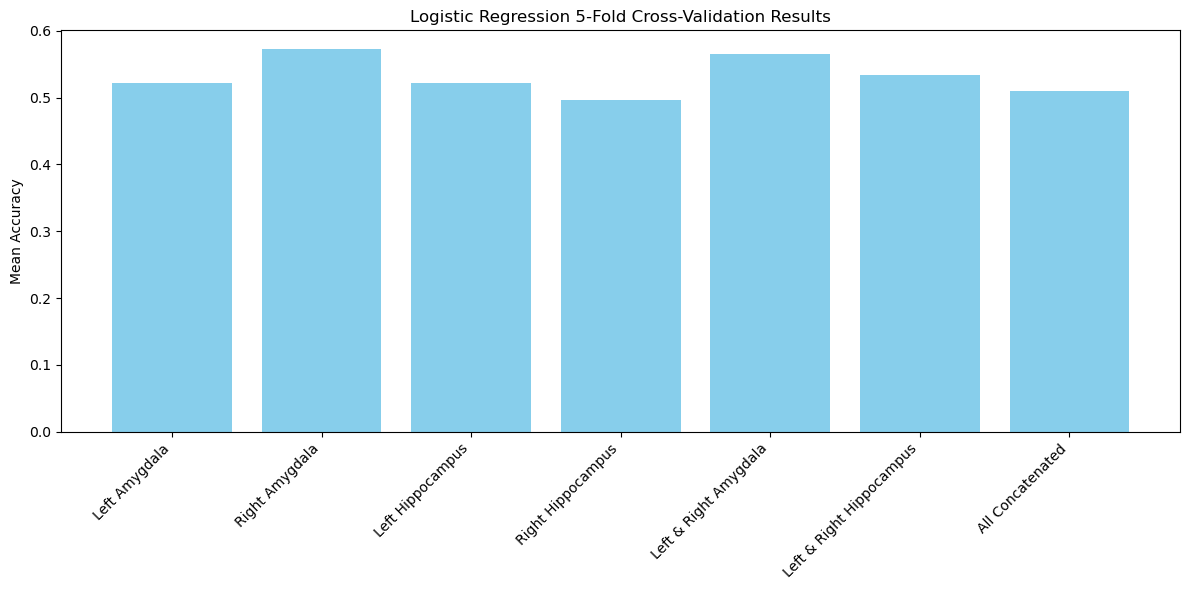

In [37]:
formatted_results = {
    'Left Amygdala': results['left_amygdala'],
    'Right Amygdala': results['right_amygdala'],
    'Left Hippocampus': results['left_hippocampus'],
    'Right Hippocampus': results['right_hippocampus'],
    'Left & Right Amygdala': results['left_right_amygdala'],
    'Left & Right Hippocampus': results['left_right_hippocampus'],
    'All Concatenated': results['all_concat']
}

# Plotting the updated bar chart
plt.figure(figsize=(12, 6))
plt.bar(formatted_results.keys(), formatted_results.values(), color='skyblue')
plt.title('Logistic Regression 5-Fold Cross-Validation Results')
plt.ylabel('Mean Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('logistic_regression_accuracy.png', dpi=300)
plt.show()

In [45]:
np.mean(list(formatted_results.values()))

np.float64(0.5316964285714286)

In [47]:
from collections import Counter

In [48]:
np.mean(labels), Counter(labels)

(np.float64(0.559375), Counter({np.int64(1): 179, np.int64(0): 141}))

In [ ]:
from sklearn.metrics import precision_score, recall_score, make_scorer

# Custom scorers for precision and recall
scorers = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

# Function to evaluate precision and recall for a given dataset
def evaluate_precision_recall(model, X, y, cv=5):
    precision_scores = cross_val_score(model, X, y, cv=cv, scoring=scorers['precision'])
    recall_scores = cross_val_score(model, X, y, cv=cv, scoring=scorers['recall'])
    return {
        'precision_mean': precision_scores.mean(),
        'recall_mean': recall_scores.mean()
    }

# Evaluating for all datasets
evaluation_results = {}

evaluation_results['Left Amygdala'] = evaluate_precision_recall(logistic_model, left_amygdala_power_bands, labels)
evaluation_results['Right Amygdala'] = evaluate_precision_recall(logistic_model, right_amygdala_power_bands, labels)
evaluation_results['Left Hippocampus'] = evaluate_precision_recall(logistic_model, left_hippocampus_power_bands, labels)
evaluation_results['Right Hippocampus'] = evaluate_precision_recall(logistic_model, right_hippocampus_power_bands, labels)
evaluation_results['Left & Right Amygdala'] = evaluate_precision_recall(logistic_model, left_right_amygdala, labels)
evaluation_results['Left & Right Hippocampus'] = evaluate_precision_recall(logistic_model, left_right_hippocampus, labels)
evaluation_results['All Concatenated'] = evaluate_precision_recall(logistic_model, all_data, labels)

# Displaying the results in a DataFrame
evaluation_df = pd.DataFrame(evaluation_results).T
evaluation_df.columns = ['Mean Precision', 'Mean Recall']

In [22]:
# Displaying the precision and recall results in a formatted table-like output

from tabulate import tabulate

# Formatting the DataFrame for better visual output
evaluation_df.reset_index(inplace=True)
evaluation_df.rename(columns={'index': 'Class'}, inplace=True)

# Printing in a tabulated format similar to the provided image
print(tabulate(evaluation_df, headers='keys', tablefmt='grid', showindex=False))


+--------------------------+------------------+---------------+
| Class                    |   Mean Precision |   Mean Recall |
+==========================+==================+===============+
| Left Amygdala            |         0.550505 |      0.769841 |
+--------------------------+------------------+---------------+
| Right Amygdala           |         0.587088 |      0.816508 |
+--------------------------+------------------+---------------+
| Left Hippocampus         |         0.549344 |      0.782063 |
+--------------------------+------------------+---------------+
| Right Hippocampus        |         0.533844 |      0.775873 |
+--------------------------+------------------+---------------+
| Left & Right Amygdala    |         0.581399 |      0.809683 |
+--------------------------+------------------+---------------+
| Left & Right Hippocampus |         0.551126 |      0.887619 |
+--------------------------+------------------+---------------+
| All Concatenated         |         0.5

In [27]:
# Rounding the DataFrame to 3 decimal places
evaluation_df_rounded = evaluation_df.round(3)

# Printing the rounded DataFrame as LaTeX table
latex_table_rounded = evaluation_df_rounded.to_latex(index=False, caption="Precision and Recall Evaluation Results", label="tab:precision_recall")
print(latex_table_rounded)


\begin{table}
\caption{Precision and Recall Evaluation Results}
\label{tab:precision_recall}
\begin{tabular}{lrr}
\toprule
Class & Mean Precision & Mean Recall \\
\midrule
Left Amygdala & 0.551000 & 0.770000 \\
Right Amygdala & 0.587000 & 0.817000 \\
Left Hippocampus & 0.549000 & 0.782000 \\
Right Hippocampus & 0.534000 & 0.776000 \\
Left & Right Amygdala & 0.581000 & 0.810000 \\
Left & Right Hippocampus & 0.551000 & 0.888000 \\
All Concatenated & 0.542000 & 0.781000 \\
\bottomrule
\end{tabular}
\end{table}



In [28]:
# Ensuring that trailing zeros are removed after rounding
latex_table_rounded_cleaned = evaluation_df_rounded.to_latex(index=False, float_format="%.3f", caption="Precision and Recall Evaluation Results", label="tab:precision_recall")
print(latex_table_rounded_cleaned)


\begin{table}
\caption{Precision and Recall Evaluation Results}
\label{tab:precision_recall}
\begin{tabular}{lrr}
\toprule
Class & Mean Precision & Mean Recall \\
\midrule
Left Amygdala & 0.551 & 0.770 \\
Right Amygdala & 0.587 & 0.817 \\
Left Hippocampus & 0.549 & 0.782 \\
Right Hippocampus & 0.534 & 0.776 \\
Left & Right Amygdala & 0.581 & 0.810 \\
Left & Right Hippocampus & 0.551 & 0.888 \\
All Concatenated & 0.542 & 0.781 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
# Custom scoring functions for label-specific precision and recall
def label_specific_scores(model, X, y, label, cv=5):
    # Precision and recall scorers for a specific label
    precision_scorer = make_scorer(precision_score, pos_label=label)
    recall_scorer = make_scorer(recall_score, pos_label=label)
    
    precision_scores = cross_val_score(model, X, y, cv=cv, scoring=precision_scorer)
    recall_scores = cross_val_score(model, X, y, cv=cv, scoring=recall_scorer)
    
    return {
        'precision_mean': precision_scores.mean(),
        'recall_mean': recall_scores.mean()
    }

# Evaluating for label 0 (Incongruent) and label 1 (Congruent) across all datasets
label_evaluation_results = {}

for dataset_name, dataset in {
    'Left Amygdala': left_amygdala_power_bands,
    'Right Amygdala': right_amygdala_power_bands,
    'Left Hippocampus': left_hippocampus_power_bands,
    'Right Hippocampus': right_hippocampus_power_bands,
    'Left & Right Amygdala': left_right_amygdala,
    'Left & Right Hippocampus': left_right_hippocampus,
    'All Concatenated': all_data
}.items():
    label_evaluation_results[dataset_name] = {
        'Incongruent': label_specific_scores(logistic_model, dataset, labels, label=0),
        'Congruent': label_specific_scores(logistic_model, dataset, labels, label=1)
    }

# Creating a DataFrame for display
evaluation_df_labels = pd.DataFrame.from_dict(
    {(i, j): label_evaluation_results[i][j] for i in label_evaluation_results.keys() for j in label_evaluation_results[i].keys()},
    orient='index'
).reset_index()

evaluation_df_labels.columns = ['Class', 'Label', 'Mean Precision', 'Mean Recall']

In [ ]:
# Generating LaTeX tables for each dataset with proper centering and labels
latex_tables_per_dataset_centered = ""

for dataset_name in label_evaluation_results.keys():
    # Clean and format dataset name for label
    label_name = dataset_name.lower().replace(" ", "_").replace("&", "and")
    
    # Filter DataFrame for current dataset
    df_subset = evaluation_df_labels[evaluation_df_labels['Class'] == dataset_name].round(2)
    df_subset = df_subset.drop(columns=['Class'])
    
    # Convert to LaTeX table
    latex_table = df_subset.to_latex(index=False, float_format="%.2f",
                                     caption=f"Precision and Recall for {dataset_name}",
                                     label=f"tab:{label_name}",
                                     column_format="ccc")
    latex_tables_per_dataset_centered += latex_table.replace('\\begin{tabular}', '\\begin{tabular}{ccc} \\centering') + "\n\n"

print(latex_tables_per_dataset_centered)


In [33]:
# Creating a horizontal LaTeX table with datasets as columns
evaluation_df_pivot = evaluation_df_labels.pivot(index='Label', columns='Class', values=['Mean Precision', 'Mean Recall']).round(2)
evaluation_df_pivot.columns = [f"{metric} ({dataset})" for metric, dataset in evaluation_df_pivot.columns]

# Generating the LaTeX table
latex_horizontal_table = evaluation_df_pivot.to_latex(float_format="%.2f", caption="Precision and Recall Across All Datasets", label="tab:precision_recall_horizontal")

print(latex_horizontal_table)


\begin{table}
\caption{Precision and Recall Across All Datasets}
\label{tab:precision_recall_horizontal}
\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
 & Mean Precision (All Concatenated) & Mean Precision (Left & Right Amygdala) & Mean Precision (Left & Right Hippocampus) & Mean Precision (Left Amygdala) & Mean Precision (Left Hippocampus) & Mean Precision (Right Amygdala) & Mean Precision (Right Hippocampus) & Mean Recall (All Concatenated) & Mean Recall (Left & Right Amygdala) & Mean Recall (Left & Right Hippocampus) & Mean Recall (Left Amygdala) & Mean Recall (Left Hippocampus) & Mean Recall (Right Amygdala) & Mean Recall (Right Hippocampus) \\
Label &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Congruent & 0.54 & 0.58 & 0.55 & 0.55 & 0.55 & 0.59 & 0.53 & 0.78 & 0.81 & 0.89 & 0.77 & 0.78 & 0.82 & 0.78 \\
Incongruent & 0.35 & 0.49 & 0.42 & 0.34 & 0.33 & 0.56 & 0.32 & 0.16 & 0.25 & 0.08 & 0.20 & 0.19 & 0.26 & 0.14 \\
\bottomrule
\end{tabular}
\end{table}



In [49]:
(
    495 +
    142.78 +
    34.53 +
    11.21 +
    17.11  +
    12.75 +
    13.48 +
    15.89 +
    13.55+
    15.51 +
    36.83 +
    20.27 +
    12.23 + 
    14.98 +
    32.07 +
    11.12 +
    36.20 +
    379.33 +
    45.94 
) 


1360.7800000000002

In [ ]:
import arviz as az


In [ ]:
# Plot posterior distributions for mu_group and sigma_group
def plot_group_posteriors(trace):
    """
    Plots posterior distributions for group-level parameters.
    """
    # Density plot for mu_group and sigma_group
    az.plot_posterior(trace, var_names=["mu_group", "sigma_group"], hdi_prob=0.95)
    plt.tight_layout()
    plt.show()

# Calculate precision and recall for congruent and incongruent trials
def calculate_metrics(labels, predicted_labels):
    """
    Calculates precision and recall for congruent (label=1) and incongruent (label=0) trials.
    """
    # Split labels into congruent and incongruent
    congruent_mask = labels == 1
    incongruent_mask = labels == 0

    # Metrics for congruent trials
    congruent_precision = precision_score(labels[congruent_mask], predicted_labels[congruent_mask], zero_division=1)
    congruent_recall = recall_score(labels[congruent_mask], predicted_labels[congruent_mask], zero_division=1)

    # Metrics for incongruent trials
    incongruent_precision = precision_score(labels[incongruent_mask], predicted_labels[incongruent_mask], zero_division=1)
    incongruent_recall = recall_score(labels[incongruent_mask], predicted_labels[incongruent_mask], zero_division=1)

    return {
        "Congruent": {"Precision": congruent_precision, "Recall": congruent_recall},
        "Incongruent": {"Precision": incongruent_precision, "Recall": incongruent_recall},
    }

# Assuming `trace` contains the posterior samples and `labels` are the true labels

# Plot posteriors for mu_group and sigma_group
plot_group_posteriors(trace)

# Calculate precision and recall for congruent and incongruent trials
metrics = calculate_metrics(labels, predicted_labels)

# Print metrics
print("Metrics for Congruent Trials:")
print(f"  Precision: {metrics['Congruent']['Precision'] * 100:.2f}%")
print(f"  Recall: {metrics['Congruent']['Recall'] * 100:.2f}%")

print("\nMetrics for Incongruent Trials:")
print(f"  Precision: {metrics['Incongruent']['Precision'] * 100:.2f}%")
print(f"  Recall: {metrics['Incongruent']['Recall'] * 100:.2f}%")
